In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pprint import pprint
import pandas as pd
import os
import cv2 
import imageio
import math
import itertools
import trackpy as tp
import datetime
import matplotlib.animation as animation
import collections
from skimage import io
import scipy.ndimage as ndi
from scipy.ndimage._ni_support import _normalize_sequence
from scipy.ndimage import gaussian_filter
import tifffile as tiff
from sklearn.cluster import DBSCAN
import ExtraFunctions as ef
import xml.etree.ElementTree as ET 
import skimage as ski
import preprocessing_Alessandro as preA # This file contains the functions to preprocess the images


In [2]:
experiment_path = r"C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23" #path of folder where the analysis will be stored
experiment_name = r"T=33,25_33,55_26,5_dm_10_Vp1_555_t36" #name of the experiment


z_stack_path = r"C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\ramp_T=33,25_33,55_26_5dm_10_Vp" #path of folder where the z-stacks are stored
z_stack_name = r"T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome"
z_stack_format = r".tf2"

In [3]:
# Creating: 1) a folder with experiment_path+experiment_name
#           2) in this folder create another folder times_series_path+times_series_name
#           3) in folder cretated in 2) create two folders one for data the other for results
timestr =  datetime.datetime.now().strftime("%Y%m%d-%H%M")
analysis_grandparent_folder = os.path.join(experiment_path,experiment_name)
analysis_parent_folder = os.path.join(analysis_grandparent_folder,z_stack_name)
analysis_data_folder = os.path.join(analysis_parent_folder,r'data')
analysis_results_folder = os.path.join(analysis_parent_folder,r'results')

if not os.path.isdir(analysis_parent_folder):
    if not os.path.isdir(analysis_grandparent_folder):
        os.mkdir(analysis_grandparent_folder)   
    os.mkdir(analysis_parent_folder)
    os.mkdir(analysis_data_folder)
    os.mkdir(analysis_results_folder)

In [4]:
raw_data_path = os.path.join(z_stack_path, z_stack_name+z_stack_format)
raw_data =tiff.imread(raw_data_path)
print(f'The image has the following {raw_data.shape} z,y,x dimensions')

The image has the following (276, 1024, 1024) z,y,x dimensions


In [5]:
with tiff.TiffFile(raw_data_path) as tif:
    metadata = tif.pages[0].tags  # Access the tags of the first page
    image_description = metadata['ImageDescription'].value  # Extract the ImageDescription tag

    # Parse the XML content
    root = ET.fromstring(image_description)

    # Define the namespace
    namespace = {'ome': "http://www.openmicroscopy.org/Schemas/OME/2016-06"}

    # Find the <Pixels> element
    pixels_elem = root.find('.//ome:Pixels', namespace)
    
    if pixels_elem is not None:
        physical_size_x = pixels_elem.get('PhysicalSizeX')
        physical_size_y = pixels_elem.get('PhysicalSizeY')
        physical_size_z = pixels_elem.get('PhysicalSizeZ')

        print(f"PhysicalSizeX: {physical_size_x}") # physical_size =  micron/pixel
        print(f"PhysicalSizeY: {physical_size_y}")
        print(f"PhysicalSizeZ: {physical_size_z}")
    else:
        physical_size_x = physical_size_y= 0.129
        physical_size_z = 0.2
        print(f"No Pixels element found in the XML metadata. Values set to default x ={physical_size_x}, physical_size_y={physical_size_y}, physical_size_z={physical_size_z}")



box_length = (raw_data.shape[0]*float(physical_size_z), raw_data.shape[1]*float(physical_size_x), raw_data.shape[2]*float(physical_size_y))
box_volume = box_length[0]*box_length[1]*box_length[2]
print(f'The raw volume has edges {box_length} micron and volume {box_volume} micron^3')

No Pixels element found in the XML metadata. Values set to default x =0.129, physical_size_y=0.129, physical_size_z=0.2
The raw volume has edges (55.2, 132.096, 132.096) micron and volume 963204.2975232002 micron^3


(165, 1024, 1024)


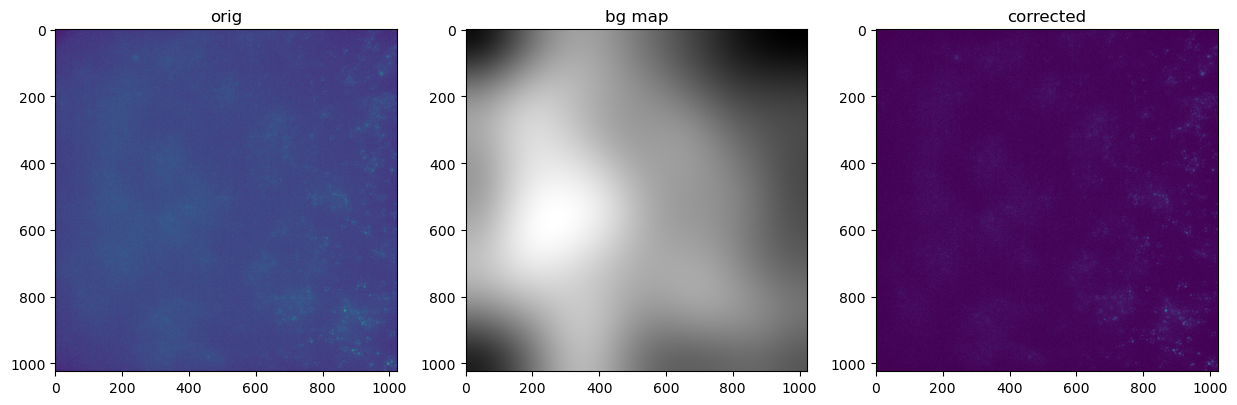

In [7]:
# Apply min-Max normalization
z_bottom = 35
z_top = 200
z_range = (z_bottom,z_top)
cut_data = preA.zcrop(raw_data,z_range)
normalized_data = preA.min_max_normalization(cut_data)

print(normalized_data.shape)

# Subtract background
corrected, alphas, bgmap = preA.subtract_gaussian_bg(normalized_data, bg_sigma=100, method='scaled_sub', low_percentile=95)
# visualize middle slice
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(normalized_data[10])
plt.title('orig')
plt.subplot(1,3,2)
plt.imshow(bgmap, cmap='gray')
plt.title('bg map')
plt.subplot(1,3,3)
plt.imshow(corrected[10])
plt.title('corrected')
plt.show()


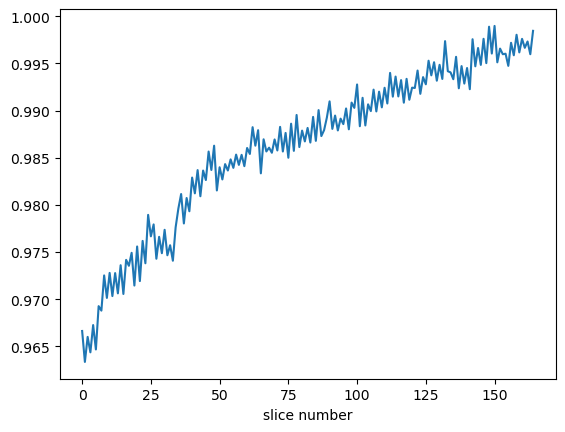

In [8]:
plt.xlabel("slice number")
plt.plot(alphas)


In [9]:
# Save the filtered z-stack as a .tif file
T = '33,35'
density_match = '26,5_dm'
#f_n = '2'
def save_corrected_tif(T, density_match, analysis_data_folder, corrected, f_n=None):
    if f_n is None:
        filename = f"T={T}_{density_match}_corrected.tif"
    else:
        filename = f"T={T}_{density_match}_{f_n}_corrected.tif"
    corrected_data_path = os.path.join(analysis_data_folder, filename)
    print(corrected_data_path)
    print(os.path.exists(corrected_data_path))
    tiff.imwrite(corrected_data_path, corrected.astype(np.uint16))    
    print(f"3D .tif file saved at {corrected_data_path}")

save_corrected_tif(T, density_match, analysis_data_folder, corrected)

C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\T=33,35_26,5_dm_corrected.tif
False
3D .tif file saved at C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\T=33,35_26,5_dm_corrected.tif


In [10]:
lshort_physical = 0.51
llong_physical = 1.
lshort_z = lshort_physical / float(physical_size_z) # in pixels round() these values for tp.bandapass()
lshort_xy = lshort_physical / float(physical_size_x)
llong_z = llong_physical/ float(physical_size_z)
llong_xy = llong_physical/ float(physical_size_x)

lshort = (lshort_z,lshort_xy,lshort_xy) # Short axis of the ellipsoid
llong = (llong_z,llong_xy,llong_xy) # Long axis of the ellipsoid  

print(lshort)
print(llong)

(2.55, 3.953488372093023, 3.953488372093023)
(5.0, 7.751937984496124, 7.751937984496124)


In [11]:
#ball_radius1 = 40
#ball_radius2 = 25
#spacing = (1, raw_data.shape[1], raw_data.shape[2])

# it looks like these are the best values for bandpass
lshort_trackpy = (3,1,1) # z,x,y 
llong_trackpy = (5,7,7) # z,x,y

params_path = os.path.join(analysis_data_folder, 'parameters.txt')
with open(params_path, 'w') as f:
    f.write(f"lshort: {lshort}\n")
    f.write(f"llong: {llong}\n")

print(f"Parameters saved to {params_path}")        

z_stack_filtered = tp.bandpass(corrected.astype(np.float64), lshort_trackpy, llong_trackpy)
z_stack_filtered_gaussian = ski.filters.gaussian(z_stack_filtered, sigma=(5.3,0.,0.), mode='nearest', preserve_range=True, truncate=4.0) # apply gaussian blur in z
#g1 = gaussian_filter(z_stack_filtered.astype(float), sigma=lshort)
#g2 = gaussian_filter(z_stack_filtered.astype(float), sigma=llong)
#z_stack_filtered_gaussian = g1 - g2
#filtered_shifted = z_stack_filtered_gaussian - z_stack_filtered_gaussian.min()  # shift min to 0
#z_stack_filtered_norm = filtered_shifted / filtered_shifted.max()  # scale to 0–1

'''
def to_odd(value):
    """Round to nearest odd integer ≥ 1"""
    return int(np.round(value)) | 1  # force odd using bitwise OR

lshort_physical = 0.5
llong_physical = 1.0

lshort_trackpy = (
    to_odd(lshort_physical / float(physical_size_z)),
    to_odd(lshort_physical / float(physical_size_x)),
    to_odd(lshort_physical / float(physical_size_y)),
)

llong_trackpy = (
    to_odd(llong_physical / float(physical_size_z)),
    to_odd(llong_physical / float(physical_size_x)),
    to_odd(llong_physical / float(physical_size_x)),
)

lshort_trackpy = (3,5,5)
llong_trackpy = (5,9,9)

print(type(z_stack_filtered_norm))
print(z_stack_filtered_norm.dtype)

print(f"lshort_trackpy: {lshort_trackpy}")
print(f"llong_trackpy: {llong_trackpy}")
z_stack_filtered = tp.bandpass(z_stack_filtered_norm.astype(float), lshort, llong)
'''
T = '33,35'
density_match = '26,5_dm'
#f_n = '2'
def save_bp_tif(T, density_match, analysis_data_folder, z_stack_filtered_gaussian, f_n=None):
    if f_n is None:
        filename = f"T={T}_{density_match}_bp.tif"
    else:
        filename = f"T={T}_{density_match}_{f_n}_bp.tif"
    filtered_data_path = os.path.join(analysis_data_folder, filename)
    print(filtered_data_path)
    print(os.path.exists(filtered_data_path))
    tiff.imwrite(filtered_data_path, z_stack_filtered_gaussian)    
    print(f"3D .tif file saved at {filtered_data_path}")

save_bp_tif(T, density_match, analysis_data_folder, z_stack_filtered_gaussian)


Parameters saved to C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\parameters.txt
C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\T=33,35_26,5_dm_bp.tif
False
3D .tif file saved at C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\T=33,35_26,5_dm_bp.tif


The patch diameter in pixels is (15, 8, 8)
Parameters saved to C:\Users\alesp\Desktop\alessandro\__________________laurea magistrale\master thesis\lab_work\2025_07_23\T=33,25_33,55_26,5_dm_10_Vp1_555_t36\T=33,25_33,55_26,5_dm_10_Vp1_555_t36.ome\data\patches_parameters.txt
The new min mass is 183.7718903864092


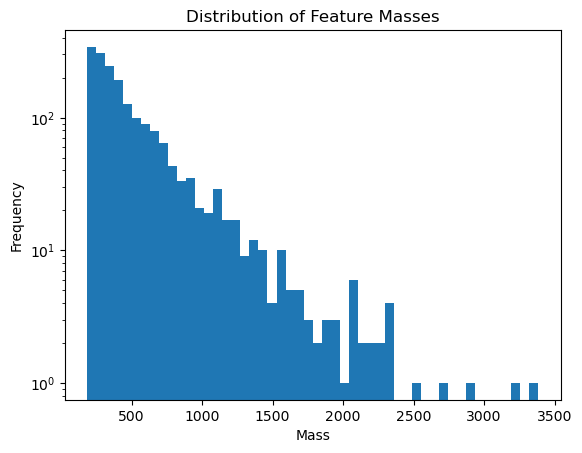

Number of patches located: 3395


,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,13.380321,52.625960,957.719470,241.631941,9.873166,2.537369,1.823702,NaN,1.236544,520.993031,0.018831,0.005182,0.005182
1,14.290333,62.109932,874.584314,338.981678,9.464128,1.828993,2.567381,NaN,1.854816,700.791010,0.015456,0.004254,0.004254
2,14.508156,114.930382,866.277308,385.914144,9.744725,2.371363,2.163234,NaN,1.854816,860.232637,0.009076,0.002498,0.002498
3,14.067977,133.035988,977.304577,660.651741,10.365611,2.925526,1.918317,NaN,2.192055,1577.515490,0.007646,0.002104,0.002104
4,13.529014,154.136099,802.035889,241.182289,9.630302,2.033396,2.748106,NaN,1.067924,553.648672,0.011629,0.003200,0.003200


In [12]:
# Use tp.locate to locate patches and get their coordinates in 3d space
patch_diameter_in_microns = (3.,1.,1.) # z,y,x in microns
patch_diameter_pixels_z = round(patch_diameter_in_microns[0] / float(physical_size_z)) # in pixels
patch_diameter_pixels_xy = round(patch_diameter_in_microns[1] / float(physical_size_x)) # in pixels
patch_diameter_in_pixels = (patch_diameter_pixels_z, patch_diameter_pixels_xy, patch_diameter_pixels_xy)  # in (z,y,x)
print(f'The patch diameter in pixels is {patch_diameter_in_pixels}')

p_dia = (29,9,9) # here we set the diameter of patches to detect cause we're gonna use it multiple times later
min_mass= 300
preprocess=True
invert = False
sep_distance_in_microns = (1.5,1.5,1.5) # distance between patches in microns (z,y,x)     
sep_distance_in_pixels_z = round(sep_distance_in_microns[0] / float(physical_size_z)) # in pixels
sep_distance_in_pixels_xy = round(sep_distance_in_microns[1] / float(physical_size_x)) # in pixels
#sep_distance = (18,10,10)  # in (z,y,x)
#print(f'The separation distance in pixels is {sep_distance}')

savetheseparameters = {'diameter' : p_dia,
                       'minmass' : min_mass,
                       'preprocess' : preprocess,
                       'invert' : invert} # This is saved so you can recreate this.
patches_params_path = os.path.join(analysis_data_folder, 'patches_parameters.txt')
with open(patches_params_path, 'w') as f:
    f.write(f"parameters: {savetheseparameters}")
print(f"Parameters saved to {patches_params_path}") 

new_minmass = tp.minmass_v04_change(z_stack_filtered_gaussian, min_mass, p_dia, preprocess=True, old_smoothing_size=None, new_smoothing_size=None)
print(f'The new min mass is {new_minmass}')
curp_r = tp.locate(z_stack_filtered_gaussian, diameter = p_dia, minmass= new_minmass, preprocess = True, threshold = None)
masses = curp_r['mass']

%matplotlib inline
# Plot the distribution of masses
plt.hist(masses, bins=50, log=True)
plt.xlabel('Mass')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Masses')
plt.show()


num_objects = len(curp_r)
print("Number of patches located:", num_objects) # see how many patches are located
# Reset the index of the DataFrame
curp_r.reset_index(drop=True, inplace=True)
curp_r.head() # show the first few rows of the data frame 


In [13]:
curp_r

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,13.380321,52.625960,957.719470,241.631941,9.873166,2.537369,1.823702,NaN,1.236544,520.993031,0.018831,0.005182,0.005182
1,14.290333,62.109932,874.584314,338.981678,9.464128,1.828993,2.567381,NaN,1.854816,700.791010,0.015456,0.004254,0.004254
2,14.508156,114.930382,866.277308,385.914144,9.744725,2.371363,2.163234,NaN,1.854816,860.232637,0.009076,0.002498,0.002498
3,14.067977,133.035988,977.304577,660.651741,10.365611,2.925526,1.918317,NaN,2.192055,1577.515490,0.007646,0.002104,0.002104
4,13.529014,154.136099,802.035889,241.182289,9.630302,2.033396,2.748106,NaN,1.067924,553.648672,0.011629,0.003200,0.003200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011530,0.003173,0.003173
3391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010990,0.003024,0.003024
3392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011741,0.003231,0.003231
3393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018731,0.005155,0.005155


c:\Users\alesp\anaconda3\envs\mycondaenv\Lib\site-packages\trackpy\plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


Features found: 3395


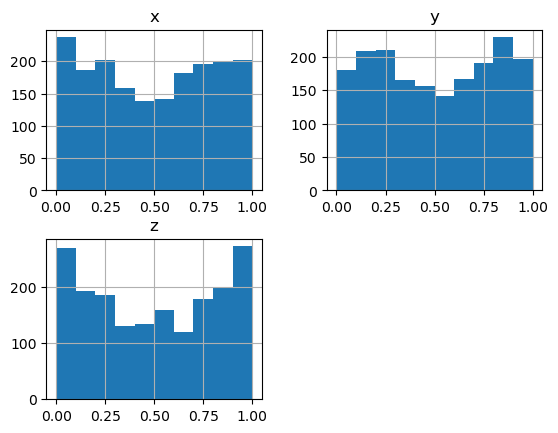

In [14]:
tp.subpx_bias(curp_r) # check if there's a bias in the subpixel localization
print('Features found: {0}'.format(len(curp_r))) # check how many features are found
# These distributions should be flat if there is no bias. If they are not, you may need to adjust the parameters of the feature-finding algorithm.

In [15]:
mask = curp_r[['z', 'y', 'x']].notna().all(axis=1) # this detects the nans
print(type(mask))

<class 'pandas.core.series.Series'>


In [16]:
remove_patches_nan = []
for i in range(len(mask)):
    if mask[i] == False:
        remove_patches_nan.append(i)

print(len(remove_patches_nan))       

1552


In [17]:
curp_r = curp_r.drop(remove_patches_nan).reset_index(drop=True) # now this contains no coordinates with nans

In [18]:
curp_r # without nans

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,13.380321,52.625960,957.719470,241.631941,9.873166,2.537369,1.823702,NaN,1.236544,520.993031,0.018831,0.005182,0.005182
1,14.290333,62.109932,874.584314,338.981678,9.464128,1.828993,2.567381,NaN,1.854816,700.791010,0.015456,0.004254,0.004254
2,14.508156,114.930382,866.277308,385.914144,9.744725,2.371363,2.163234,NaN,1.854816,860.232637,0.009076,0.002498,0.002498
3,14.067977,133.035988,977.304577,660.651741,10.365611,2.925526,1.918317,NaN,2.192055,1577.515490,0.007646,0.002104,0.002104
4,13.529014,154.136099,802.035889,241.182289,9.630302,2.033396,2.748106,NaN,1.067924,553.648672,0.011629,0.003200,0.003200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,117.863833,22.772188,137.016479,194.418442,8.739112,3.005055,2.117740,NaN,0.786892,483.351776,NaN,NaN,NaN
1839,120.944449,309.988872,818.031769,626.309541,13.340874,1.601960,1.606994,NaN,3.428599,1060.984776,NaN,NaN,NaN
1840,124.184178,135.972511,247.361943,184.020231,12.417928,2.203318,1.612319,NaN,0.899305,423.108855,NaN,NaN,NaN
1841,125.463562,22.179619,114.685516,185.875047,9.725659,2.043228,2.845269,NaN,0.786892,462.352779,NaN,NaN,NaN


In [19]:
filename = f'T={T}_26,5_dm'
patches_raw = os.path.join(analysis_results_folder, f'{filename}.csv')

In [20]:
curp_r.to_csv(patches_raw, index = False) #save the coordinates of the patches in a csv file

In [21]:
patches_raw_df = pd.read_csv(patches_raw)
patches_raw_df

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,13.380321,52.625960,957.719470,241.631941,9.873166,2.537369,1.823702,NaN,1.236544,520.993031,0.018831,0.005182,0.005182
1,14.290333,62.109932,874.584314,338.981678,9.464128,1.828993,2.567381,NaN,1.854816,700.791010,0.015456,0.004254,0.004254
2,14.508156,114.930382,866.277308,385.914144,9.744725,2.371363,2.163234,NaN,1.854816,860.232637,0.009076,0.002498,0.002498
3,14.067977,133.035988,977.304577,660.651741,10.365611,2.925526,1.918317,NaN,2.192055,1577.515490,0.007646,0.002104,0.002104
4,13.529014,154.136099,802.035889,241.182289,9.630302,2.033396,2.748106,NaN,1.067924,553.648672,0.011629,0.003200,0.003200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,117.863833,22.772188,137.016479,194.418442,8.739112,3.005055,2.117740,NaN,0.786892,483.351776,NaN,NaN,NaN
1839,120.944449,309.988872,818.031769,626.309541,13.340874,1.601960,1.606994,NaN,3.428599,1060.984776,NaN,NaN,NaN
1840,124.184178,135.972511,247.361943,184.020231,12.417928,2.203318,1.612319,NaN,0.899305,423.108855,NaN,NaN,NaN
1841,125.463562,22.179619,114.685516,185.875047,9.725659,2.043228,2.845269,NaN,0.786892,462.352779,NaN,NaN,NaN


In [22]:
patches_microns_path = os.path.join(analysis_results_folder, f'{filename}_microns.csv') 
# Convert pixel coordinates to microns
patches_microns = curp_r.copy()
patches_microns['z_true'] = patches_microns['z'] * float(physical_size_z)
patches_microns['y_true'] = patches_microns['y'] * float(physical_size_y)
patches_microns['x_true'] = patches_microns['x'] * float(physical_size_x)
patches_microns.to_csv(patches_microns_path, index = False) 

In [23]:
patches_microns

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x,z_true,y_true,x_true
0,13.380321,52.625960,957.719470,241.631941,9.873166,2.537369,1.823702,NaN,1.236544,520.993031,0.018831,0.005182,0.005182,2.676064,6.788749,123.545812
1,14.290333,62.109932,874.584314,338.981678,9.464128,1.828993,2.567381,NaN,1.854816,700.791010,0.015456,0.004254,0.004254,2.858067,8.012181,112.821377
2,14.508156,114.930382,866.277308,385.914144,9.744725,2.371363,2.163234,NaN,1.854816,860.232637,0.009076,0.002498,0.002498,2.901631,14.826019,111.749773
3,14.067977,133.035988,977.304577,660.651741,10.365611,2.925526,1.918317,NaN,2.192055,1577.515490,0.007646,0.002104,0.002104,2.813595,17.161642,126.072290
4,13.529014,154.136099,802.035889,241.182289,9.630302,2.033396,2.748106,NaN,1.067924,553.648672,0.011629,0.003200,0.003200,2.705803,19.883557,103.462630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838,117.863833,22.772188,137.016479,194.418442,8.739112,3.005055,2.117740,NaN,0.786892,483.351776,NaN,NaN,NaN,23.572767,2.937612,17.675126
1839,120.944449,309.988872,818.031769,626.309541,13.340874,1.601960,1.606994,NaN,3.428599,1060.984776,NaN,NaN,NaN,24.188890,39.988564,105.526098
1840,124.184178,135.972511,247.361943,184.020231,12.417928,2.203318,1.612319,NaN,0.899305,423.108855,NaN,NaN,NaN,24.836836,17.540454,31.909691
1841,125.463562,22.179619,114.685516,185.875047,9.725659,2.043228,2.845269,NaN,0.786892,462.352779,NaN,NaN,NaN,25.092712,2.861171,14.794432


In [29]:
patches = pd.read_csv(patches_raw)
patch_coo = {index: [row['z'], row['y'], row['x']] for index, row in patches.iterrows()} # dict with all the patches

patches found after filtering 18 in z-slice 35 with z-tolerance 3


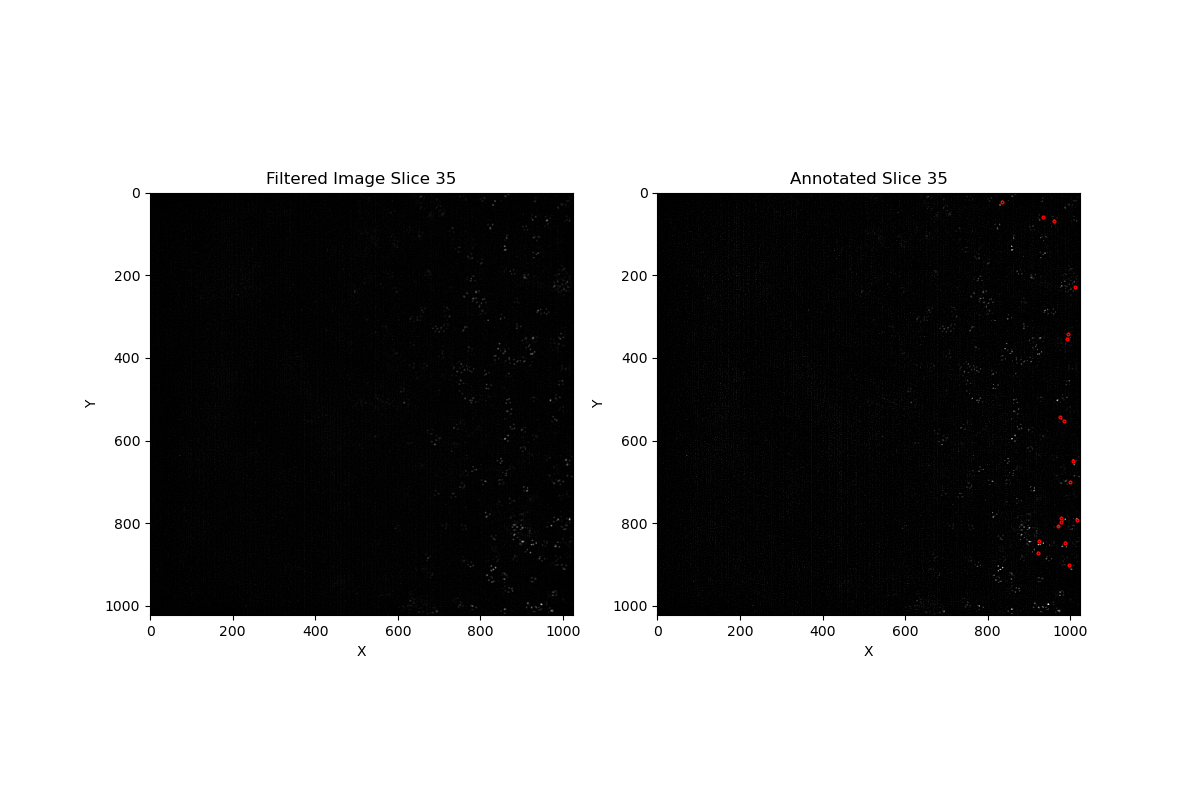

In [31]:
%matplotlib widget
patches = pd.read_csv(patches_raw) #load the coordinates of the patches from the csv file

# Visualize the results for a specific z-slice
# Define the z-slice index to visualize
z_slice_index = 35

# Filter the detected particles for this z-slice
z_tolerance = 3 # Define a tolerance range for the z-coordinate
filtered_patches = patches[
    (patches['z'] > z_slice_index - z_tolerance) & 
    (patches['z'] < z_slice_index + z_tolerance)
]

#physical_size_x = float(physical_size_x)
#physical_size_y= float(physical_size_y)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Display the filtered image slice
#axes[0].imshow(filtered_data[z_slice_index, :, :], cmap='gray')

axes[0].imshow(z_stack_filtered_gaussian[z_slice_index, :, :], cmap='gray')
axes[0].set_title(f'Filtered Image Slice {z_slice_index}')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Display the annotated image slice
axes[1].imshow(z_stack_filtered_gaussian[z_slice_index, :, :], cmap='gray')
tp.annotate(filtered_patches, z_stack_filtered_gaussian[z_slice_index, :, :], ax=axes[1], color='red')
axes[1].set_title(f'Annotated Slice {z_slice_index}')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Customize marker size separately (manually adjusting after annotation)
for line in axes[1].lines:  # `tp.annotate` adds detections as lines
    line.set_markersize(1)  # Adjust marker size
    line.set_markerfacecolor('none')  # Adjust marker face color
    line.set_markeredgecolor('red')  # Adjust marker edge color

# Show the plot
print(f'patches found after filtering {len(filtered_patches)} in z-slice {z_slice_index} with z-tolerance {z_tolerance}')
plt.show()